In [ ]:
1. ## Importing the IMDB dataset

We import the necessary libraries and load the example dataset, which consists of the reviews of IMDB



In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [7]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [8]:
# Load and prepare the dataset
imdb_df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
#set style
imdb_df.head()

print(f"Full data set : {len(imdb_df)}")


Full data set : 50000


## Creating a stratified sample of the dataset

Since the dataset is more than 50k reviews we want to be able to review a smaller subset

In [9]:
# creating a stratified sample fo 25k reviews
imdb_df_25 = (
    imdb_df
    .groupby('sentiment', group_keys=False)
    .sample(n=12_500, random_state=42)
    .reset_index(drop=True)
)

print(f"Subsample size: {len(imdb_df_25)}")
print(imdb_df_25['sentiment'].value_counts())



Subsample size: 25000
sentiment
negative    12500
positive    12500
Name: count, dtype: int64


Training - Test Split

In [10]:
train_df, test_df = train_test_split(
    imdb_df_25,
    test_size=0.2,
    stratify=imdb_df_25['sentiment'],
    random_state=42
)

train_df = train_df.copy()
test_df = test_df.copy()

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Label distribution (train): {train_df['sentiment'].value_counts().to_dict()}")


Training samples: 20000
Test samples: 5000
Label distribution (train): {'positive': 10000, 'negative': 10000}


# ount 

In [11]:
#Character length
train_df['review'] = train_df['review'].astype(str)
test_df['review'] = test_df['review'].astype(str)

train_df['char_length'] = train_df['review'].apply(len)
test_df['char_length'] = test_df['review'].apply(len)

train_df['char_length'].describe()


count    20000.000000
mean      1305.914300
std        979.235485
min         41.000000
25%        700.000000
50%        969.000000
75%       1596.000000
max      12129.000000
Name: char_length, dtype: float64

In [12]:
train_df['token_length'] = train_df['review'].apply(lambda x: len(x.split()))
test_df['token_length'] = test_df['review'].apply(lambda x: len(x.split()))

train_df['token_length'].describe()


count    20000.000000
mean       230.505900
std        169.531966
min          4.000000
25%        127.000000
50%        173.000000
75%        281.000000
max       2125.000000
Name: token_length, dtype: float64

In [13]:
train_df.groupby('sentiment')[['char_length', 'token_length']].describe()


char_length                                                        \
                count       mean          std   min     25%    50%      75%   
sentiment                                                                     
negative      10000.0  1295.3701   947.188019  41.0  708.00  971.5  1587.25   
positive      10000.0  1316.4585  1010.204259  65.0  691.75  967.0  1608.25   

                   token_length                                            \
               max        count      mean         std   min    25%    50%   
sentiment                                                                   
negative    7761.0      10000.0  229.6343  164.886222   4.0  128.0  174.0   
positive   12129.0      10000.0  231.3775  174.057644  10.0  124.0  171.5   

                          
             75%     max  
sentiment                 
negative   281.0  1376.0  
positive   281.0  2125.0

## Exploratory Data Analysis

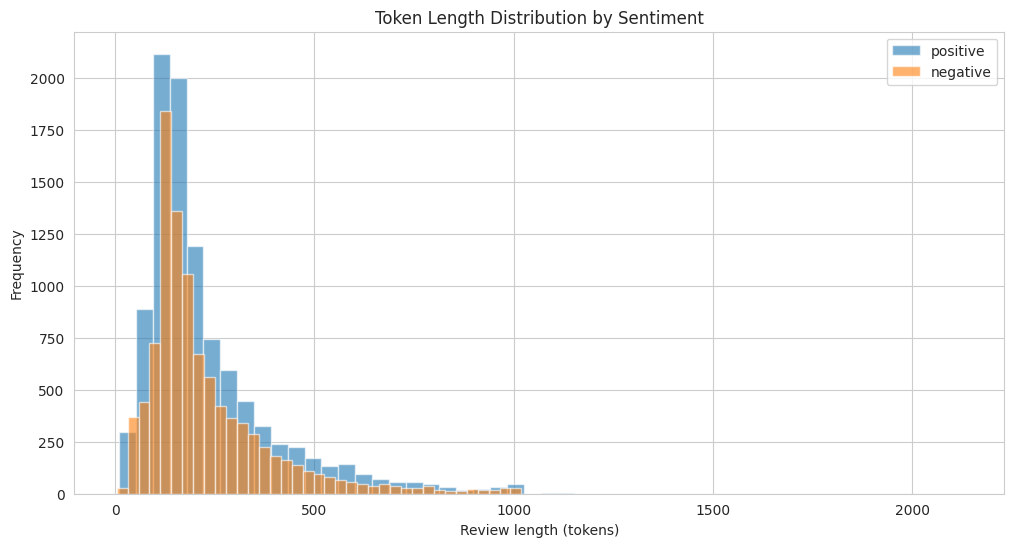

In [14]:
for label in train_df['sentiment'].unique():
    subset = train_df[train_df['sentiment'] == label]
    plt.hist(subset['token_length'], bins=50, alpha=0.6, label=label)

plt.xlabel("Review length (tokens)")
plt.ylabel("Frequency")
plt.title("Token Length Distribution by Sentiment")
plt.legend()
plt.show()


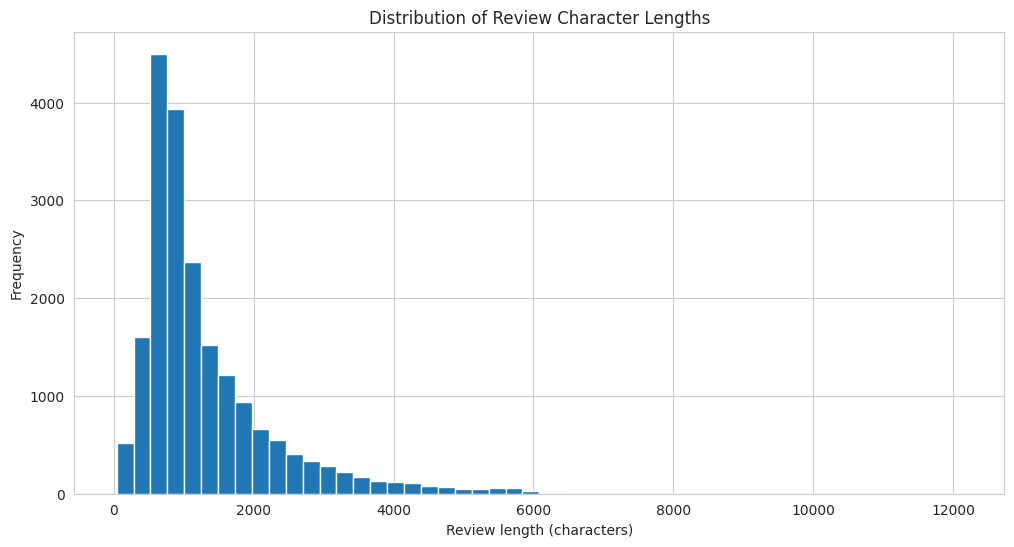

In [15]:
plt.hist(train_df['char_length'], bins=50)
plt.xlabel("Review length (characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Review Character Lengths")
plt.show()


In [16]:
# CountVectorizer for LDA
count_vectorizer = CountVectorizer(
    max_df=0.95,        # ignore very common words
    min_df=10,          # ignore very rare words
    stop_words='english',
    max_features=10_000
)

train_bow = count_vectorizer.fit_transform(train_df['review'])

print("Bag-of-Words shape:", train_bow.shape)


Bag-of-Words shape: (20000, 10000)


In [17]:
n_topics = 20

lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method='batch',
    max_iter=10
)

document_topic_matrix = lda.fit_transform(train_bow)

print("Document–Topic matrix shape:", document_topic_matrix.shape)


Document–Topic matrix shape: (20000, 20)


In [19]:
doc_topic_df = pd.DataFrame(
    document_topic_matrix,
    columns=[f"topic_{i}" for i in range(n_topics)],
    index=train_df.index
)

doc_topic_df.head()


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
20022,0.000463,0.049739,0.000463,0.000463,0.086743,0.000463,0.000463,0.216914,0.168439,0.000463,0.000463,0.000463,0.000463,0.000463,0.000463,0.247509,0.000463,0.000463,0.000463,0.224174
4993,0.000610,0.295018,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610,0.157503,0.000610,0.125928,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610,0.104899,0.307506
24760,0.157838,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.233920,0.000806,0.000806,0.360006,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.235332
13775,0.054358,0.000287,0.000287,0.000287,0.062635,0.000287,0.021474,0.000287,0.000287,0.229539,0.000287,0.000287,0.000287,0.000287,0.000287,0.031699,0.056614,0.215652,0.000287,0.324580
20504,0.001923,0.162263,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.135077,0.196558,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.475332,0.001923


In [20]:
term_topic_matrix = lda.components_.T

# Normalize to probabilities
term_topic_matrix = term_topic_matrix / term_topic_matrix.sum(axis=0, keepdims=True)

term_topic_df = pd.DataFrame(
    term_topic_matrix,
    index=count_vectorizer.get_feature_names_out(),
    columns=[f"topic_{i}" for i in range(n_topics)]
)

term_topic_df.head()


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
00,4.132773e-05,8.089263e-07,0.000001,0.000094,0.000132,3.509736e-06,0.000202,6.807445e-07,5.596180e-07,5.446923e-07,1.206639e-05,5.256572e-07,7.542237e-07,0.000313,3.582409e-07,0.000001,9.397578e-07,1.559361e-04,2.656493e-07,2.238573e-04
000,5.472156e-07,3.444002e-04,0.000143,0.000018,0.000002,2.449053e-04,0.000007,3.911618e-04,2.150463e-05,1.510524e-04,3.451890e-04,2.631318e-05,1.095129e-06,0.000250,1.181973e-05,0.000006,5.530887e-05,1.052164e-04,3.682271e-05,4.040154e-05
007,5.466689e-07,8.089262e-07,0.000001,0.000001,0.001333,2.505355e-07,0.000001,6.807444e-07,5.596179e-07,5.446923e-07,2.245345e-07,5.256572e-07,7.542237e-07,0.000001,3.582409e-07,0.000001,3.921568e-07,3.735901e-07,2.656493e-07,3.108242e-07
10,6.493797e-04,1.429429e-04,0.003871,0.001706,0.003177,1.799450e-03,0.000648,4.775895e-04,1.447477e-03,2.493169e-03,1.009123e-03,7.466905e-04,8.878832e-04,0.000154,2.014143e-03,0.001025,1.572245e-03,1.256507e-03,2.125954e-04,7.394108e-03
100,5.513525e-06,1.507763e-04,0.000257,0.000001,0.000002,2.894662e-04,0.000167,4.374870e-04,1.238951e-04,2.379973e-05,3.271383e-04,1.312090e-05,2.547552e-04,0.000156,1.165482e-04,0.000008,2.176424e-05,2.277376e-04,6.624026e-05,5.309216e-04


In [22]:
def display_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx}:")
        print(" ".join([
            feature_names[i]
            for i in topic.argsort()[:-n_top_words - 1:-1]
        ]))

feature_names = count_vectorizer.get_feature_names_out()

display_topics(lda, feature_names, n_top_words=10)

topic_sentiment_df = pd.concat(
    [doc_topic_df, train_df['sentiment']],
    axis=1
)

topic_sentiment_df.groupby('sentiment').mean().T.head(10)


Topic 0:
br film story wife life character man love father mother

Topic 1:
br war series american western john man later james police

Topic 2:
br good like match great time charlie watch new just

Topic 3:
film war movie best performance time series story great acting

Topic 4:
tony game film like eddie br bond harry original sean

Topic 5:
br movie bad like just film good really guy don

Topic 6:
episode funny br comedy time series love just season episodes

Topic 7:
film films music time br documentary like people short work

Topic 8:
film movie book br great story good version character read

Topic 9:
br movie good great best character film time man little

Topic 10:
br film movie people just like time story know make

Topic 11:
movie like film really good people think just kids great

Topic 12:
film comedy movie funny great good just cast like br

Topic 13:
br man dance young kelly film dancing love woman life

Topic 14:
br movie film story like characters just action good reall

sentiment,negative,positive
topic_0,0.024769,0.054953
topic_1,0.019325,0.031829
topic_2,0.015404,0.025379
topic_3,0.011864,0.032641
topic_4,0.012619,0.013909
topic_5,0.141896,0.028980
topic_6,0.018417,0.031687
topic_7,0.029196,0.044574
topic_8,0.034414,0.072213
topic_9,0.038426,0.053112


In [23]:
topic_sentiment_df = pd.concat(
    [doc_topic_df, train_df['sentiment']],
    axis=1
)

topic_sentiment_df.groupby('sentiment').mean().T.head(10)


sentiment,negative,positive
topic_0,0.024769,0.054953
topic_1,0.019325,0.031829
topic_2,0.015404,0.025379
topic_3,0.011864,0.032641
topic_4,0.012619,0.013909
topic_5,0.141896,0.028980
topic_6,0.018417,0.031687
topic_7,0.029196,0.044574
topic_8,0.034414,0.072213
topic_9,0.038426,0.053112


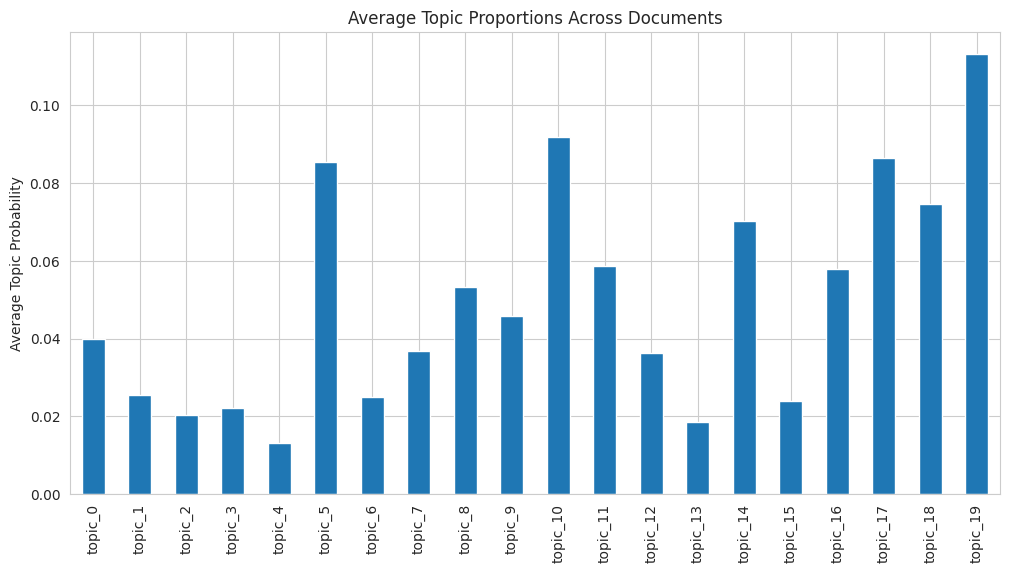

In [24]:
doc_topic_df.drop(columns='dominant_topic', errors='ignore').mean().plot(
    kind='bar',
    title='Average Topic Proportions Across Documents'
)
plt.ylabel("Average Topic Probability")
plt.show()


In [25]:
# Merge Topic Distributions with Sentiment Labels

topic_sentiment_df = doc_topic_df.copy()
topic_sentiment_df['sentiment'] = train_df['sentiment'].values

topic_sentiment_df.head()


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,sentiment
20022,0.000463,0.049739,0.000463,0.000463,0.086743,0.000463,0.000463,0.216914,0.168439,0.000463,...,0.000463,0.000463,0.000463,0.000463,0.247509,0.000463,0.000463,0.000463,0.224174,positive
4993,0.000610,0.295018,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610,0.157503,0.000610,...,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610,0.104899,0.307506,negative
24760,0.157838,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.233920,0.000806,...,0.360006,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.235332,positive
13775,0.054358,0.000287,0.000287,0.000287,0.062635,0.000287,0.021474,0.000287,0.000287,0.229539,...,0.000287,0.000287,0.000287,0.000287,0.031699,0.056614,0.215652,0.000287,0.324580,positive
20504,0.001923,0.162263,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,...,0.196558,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.475332,0.001923,positive


In [26]:
# Average Topic Prevalence by Sentiment

topic_means_by_sentiment = (
    topic_sentiment_df
    .groupby('sentiment')
    .mean()
)

topic_means_by_sentiment


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
sentiment,,,,,,,,,,,,,,,,,,,,
negative,0.024769,0.019325,0.015404,0.011864,0.012619,0.141896,0.018417,0.029196,0.034414,0.038426,0.115169,0.048980,0.029460,0.014162,0.047035,0.027962,0.058049,0.146521,0.041400,0.124931
positive,0.054953,0.031829,0.025379,0.032641,0.013909,0.028980,0.031687,0.044574,0.072213,0.053112,0.068785,0.068516,0.043011,0.023137,0.093513,0.019729,0.058038,0.026669,0.107885,0.101440


In [27]:
#8.9.3 Difference in Topic Prevalence (Positive − Negative)

topic_diff = (
    topic_means_by_sentiment.loc['positive']
    - topic_means_by_sentiment.loc['negative']
).sort_values(ascending=False)

topic_diff


topic_18    0.066485
topic_14    0.046477
topic_8     0.037798
topic_0     0.030185
topic_3     0.020777
topic_11    0.019536
topic_7     0.015378
topic_9     0.014686
topic_12    0.013551
topic_6     0.013270
topic_1     0.012504
topic_2     0.009975
topic_13    0.008975
topic_4     0.001290
topic_16   -0.000011
topic_15   -0.008234
topic_19   -0.023491
topic_10   -0.046384
topic_5    -0.112916
topic_17   -0.119852
dtype: float64

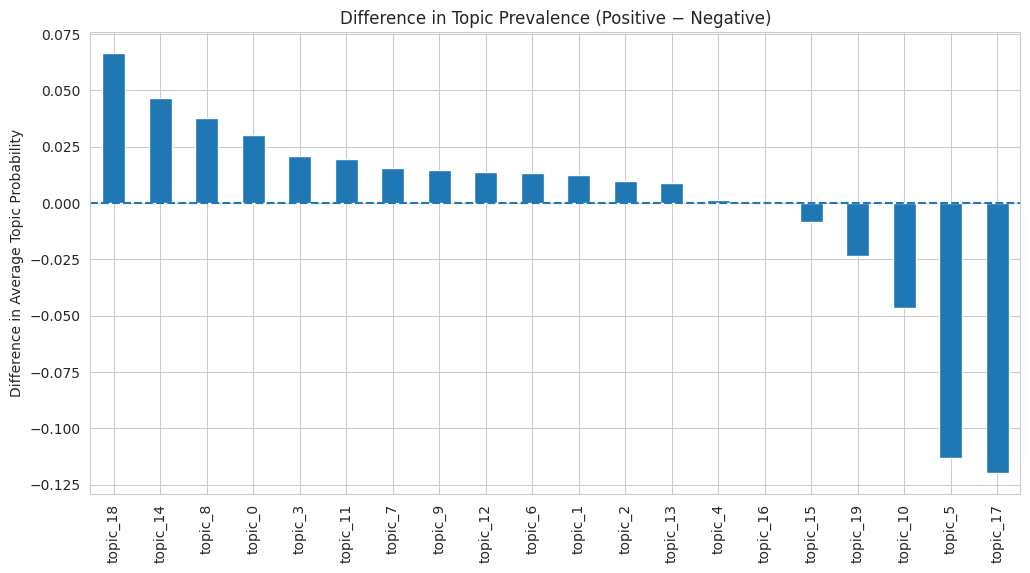

In [28]:
# Visualizing Topic Differences

topic_diff.plot(
    kind='bar',
    title='Difference in Topic Prevalence (Positive − Negative)'
)

plt.axhline(0, linestyle='--')
plt.ylabel("Difference in Average Topic Probability")
plt.show()


BERT



In [30]:
!pip install bertopic sentence-transformers umap-learn hdbscan
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import numpy as np


2025-12-26 14:25:31.282720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766759131.483457      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766759131.541457      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766759132.011588      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766759132.011625      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766759132.011628      55 computation_placer.cc:177] computation placer alr

In [35]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [37]:
topic_model = BERTopic(
    embedding_model=embedding_model,
    verbose=True,
    min_topic_size=50
)

topics, probs = topic_model.fit_transform(docs)


2025-12-26 14:27:32,662 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

2025-12-26 14:28:17,316 - BERTopic - Embedding - Completed ✓
2025-12-26 14:28:17,317 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-26 14:28:46,496 - BERTopic - Dimensionality - Completed ✓
2025-12-26 14:28:46,497 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-26 14:28:50,090 - BERTopic - Cluster - Completed ✓
2025-12-26 14:28:50,099 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-26 14:28:52,856 - BERTopic - Representation - Completed ✓


In [42]:
bert_topic_df = pd.DataFrame({
    "topic": topics,
    "sentiment": sentiments
})

bert_topic_df.head()

#Remove outliers

bert_topic_df = bert_topic_df[bert_topic_df['topic'] != -1]


In [43]:
#Topic Distribution by Sentiment (BERT)

topic_sentiment_counts = (
    bert_topic_df
    .groupby(['sentiment', 'topic'])
    .size()
    .unstack(fill_value=0)
)

topic_sentiment_counts


topic,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
sentiment,,,,,,,,,,,,,,,,,,,,,
negative,1452,326,501,212,217,253,146,174,107,140,...,54,33,28,24,22,59,19,35,49,14
positive,437,502,235,392,316,237,173,122,163,91,...,19,38,42,45,46,5,44,22,7,37


In [44]:
# Normalize to proportions:

topic_sentiment_props = topic_sentiment_counts.div(
    topic_sentiment_counts.sum(axis=1), axis=0
)

topic_sentiment_props


topic,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
sentiment,,,,,,,,,,,,,,,,,,,,,
negative,0.291566,0.065462,0.100602,0.042570,0.043574,0.050803,0.029317,0.034940,0.021486,0.028112,...,0.010843,0.006627,0.005622,0.004819,0.004418,0.011847,0.003815,0.007028,0.009839,0.002811
positive,0.099409,0.114195,0.053458,0.089172,0.071884,0.053913,0.039354,0.027753,0.037079,0.020701,...,0.004322,0.008644,0.009554,0.010237,0.010464,0.001137,0.010009,0.005005,0.001592,0.008417


In [45]:
# Topic Polarization (Positive − Negative)

topic_diff_bert = (
    topic_sentiment_props.loc['positive']
    - topic_sentiment_props.loc['negative']
).sort_values(ascending=False)

topic_diff_bert


topic
1     0.048733
3     0.046602
4     0.028309
14    0.023107
12    0.021471
13    0.018742
8     0.015593
22    0.014971
15    0.014087
21    0.013713
18    0.012789
6     0.010037
11    0.008555
28    0.008495
26    0.006862
25    0.006567
35    0.006194
33    0.006046
38    0.005605
32    0.005417
23    0.004465
31    0.003932
16    0.003220
5     0.003109
30    0.002018
19    0.000316
36   -0.002024
24   -0.003244
29   -0.006521
7    -0.007187
9    -0.007412
37   -0.008247
27   -0.009894
34   -0.010710
17   -0.010713
20   -0.015785
10   -0.017918
2    -0.047145
0    -0.192158
dtype: float64

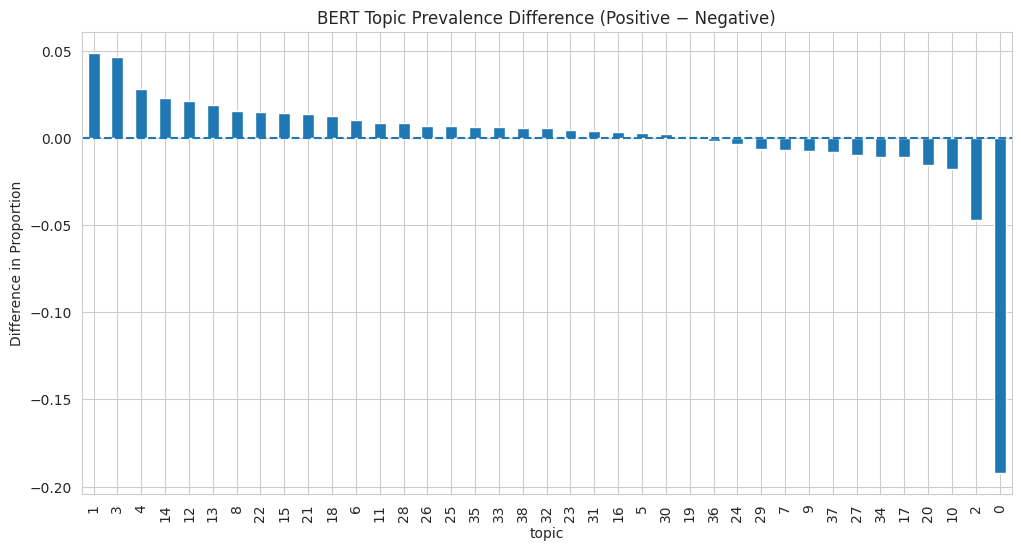

In [46]:
# Visualize Topic Differences

topic_diff_bert.plot(
    kind='bar',
    title='BERT Topic Prevalence Difference (Positive − Negative)'
)

plt.axhline(0, linestyle='--')
plt.ylabel("Difference in Proportion")
plt.show()


In [48]:
#Interpret Polarized BERT Topics

#Most positive-associated topics

top_pos_topics = topic_diff_bert.head(5).index.tolist()
top_neg_topics = topic_diff_bert.tail(5).index.tolist()


In [49]:
#Inspect topic words

for topic_id in top_pos_topics:
    print(f"\nPositive Topic {topic_id}:")
    print(topic_model.get_topic(topic_id))



Positive Topic 1:
[('show', np.float64(0.03963549256271103)), ('the', np.float64(0.020137505997659177)), ('and', np.float64(0.01858346313283246)), ('it', np.float64(0.017338130197692318)), ('to', np.float64(0.01733474130264965)), ('br', np.float64(0.016233255989495588)), ('that', np.float64(0.016102589913723632)), ('of', np.float64(0.015756439126168264)), ('episode', np.float64(0.01533626248152917)), ('is', np.float64(0.014592735229738255))]

Positive Topic 3:
[('the', np.float64(0.021544799608355262)), ('and', np.float64(0.019004695832426238)), ('of', np.float64(0.01871160672617821)), ('to', np.float64(0.01697501850412093)), ('is', np.float64(0.016757796990018885)), ('br', np.float64(0.015917447423441887)), ('in', np.float64(0.015799745535399957)), ('it', np.float64(0.013717627841755063)), ('that', np.float64(0.01330616154335287)), ('this', np.float64(0.013103918249291805))]

Positive Topic 4:
[('the', np.float64(0.02075732345884656)), ('and', np.float64(0.019132467247822766)), ('it'

In [50]:
for topic_id in top_neg_topics:
    print(f"\nNegative Topic {topic_id}:")
    print(topic_model.get_topic(topic_id))



Negative Topic 17:
[('sex', np.float64(0.019430102308611447)), ('the', np.float64(0.018364290187614315)), ('of', np.float64(0.017552622127939524)), ('and', np.float64(0.01744772234224341)), ('it', np.float64(0.01705265227176995)), ('is', np.float64(0.016725998784111233)), ('to', np.float64(0.016283484312993295)), ('br', np.float64(0.01622072097959292)), ('that', np.float64(0.01543503284281017)), ('this', np.float64(0.01498715052709716))]

Negative Topic 20:
[('zombie', np.float64(0.051361783775263514)), ('zombies', np.float64(0.04186213976442062)), ('the', np.float64(0.0214832980649881)), ('of', np.float64(0.017923396537303078)), ('to', np.float64(0.017529238137445478)), ('and', np.float64(0.016863224961067586)), ('this', np.float64(0.01607928433714124)), ('br', np.float64(0.015886085207820297)), ('it', np.float64(0.015729059210932785)), ('is', np.float64(0.014519923051255088))]

Negative Topic 10:
[('vampire', np.float64(0.030702355827204535)), ('the', np.float64(0.021835495543826546

In [52]:
topic_model.visualize_barchart(top_n_topics=15)


In [53]:
topic_model.visualize_topics()


In [54]:
#Topic Word Importance (Per Topic)

topic_model.visualize_term_rank()


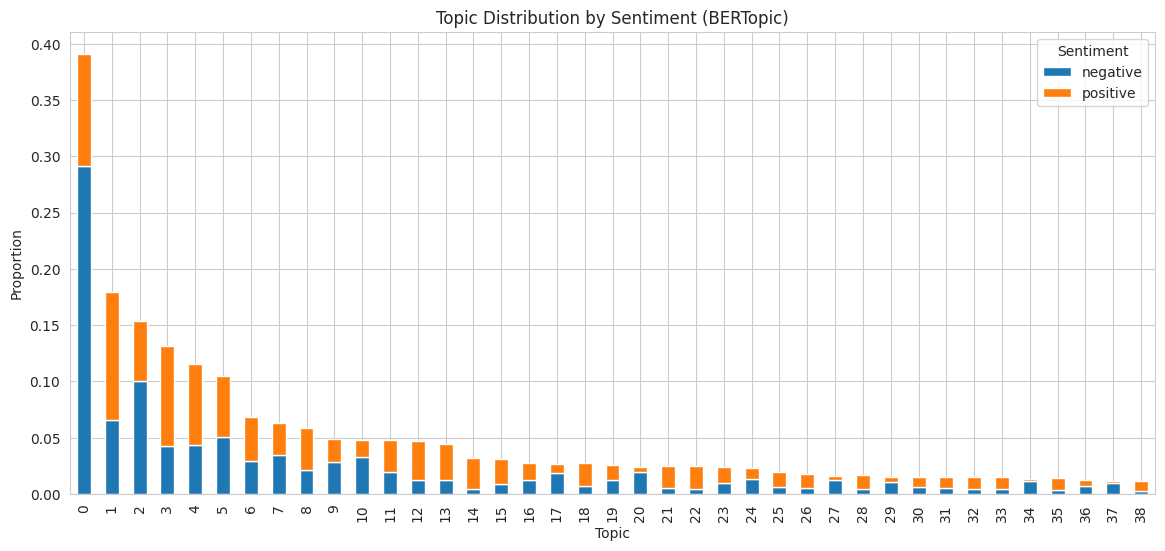

In [55]:
import matplotlib.pyplot as plt

topic_sentiment_props.T.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 6)
)

plt.title("Topic Distribution by Sentiment (BERTopic)")
plt.xlabel("Topic")
plt.ylabel("Proportion")
plt.legend(title="Sentiment")
plt.show()


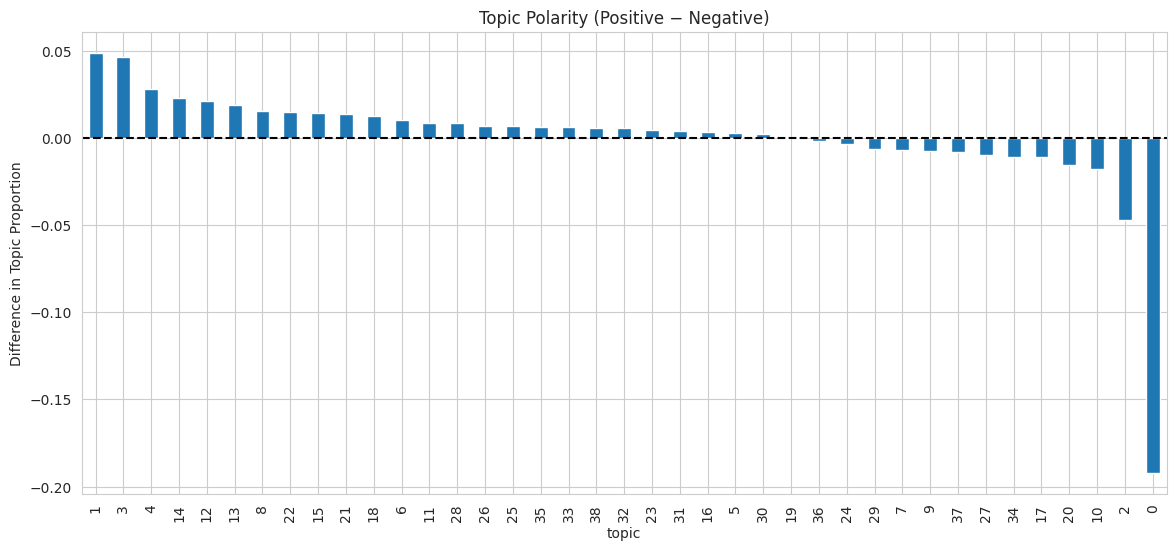

In [56]:
#Visualizing Topic Polarity
topic_diff_bert.plot(
    kind='bar',
    figsize=(14, 6),
    title="Topic Polarity (Positive − Negative)"
)

plt.axhline(0, linestyle='--', color='black')
plt.ylabel("Difference in Topic Proportion")
plt.show()


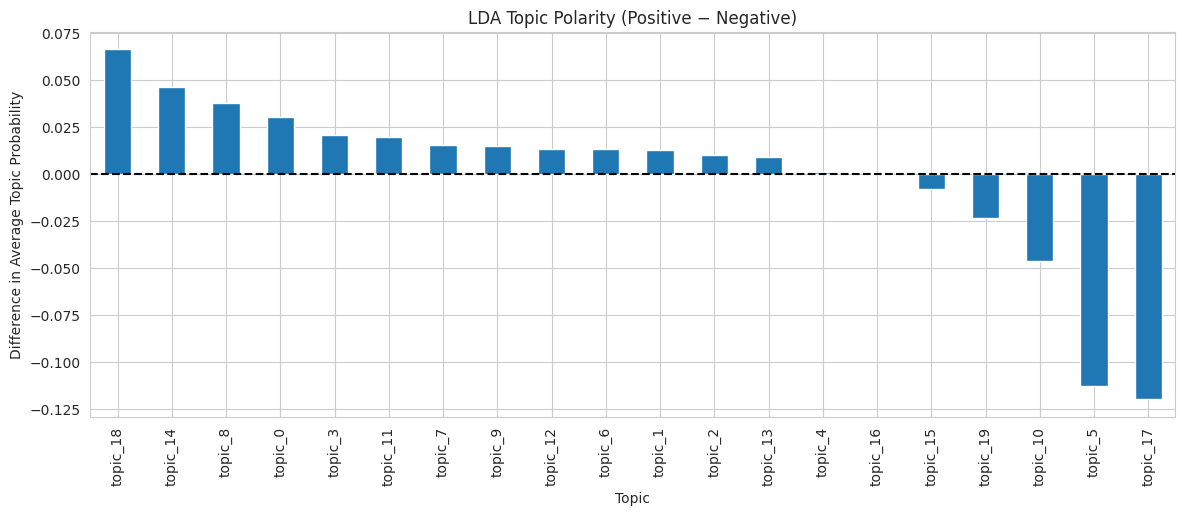

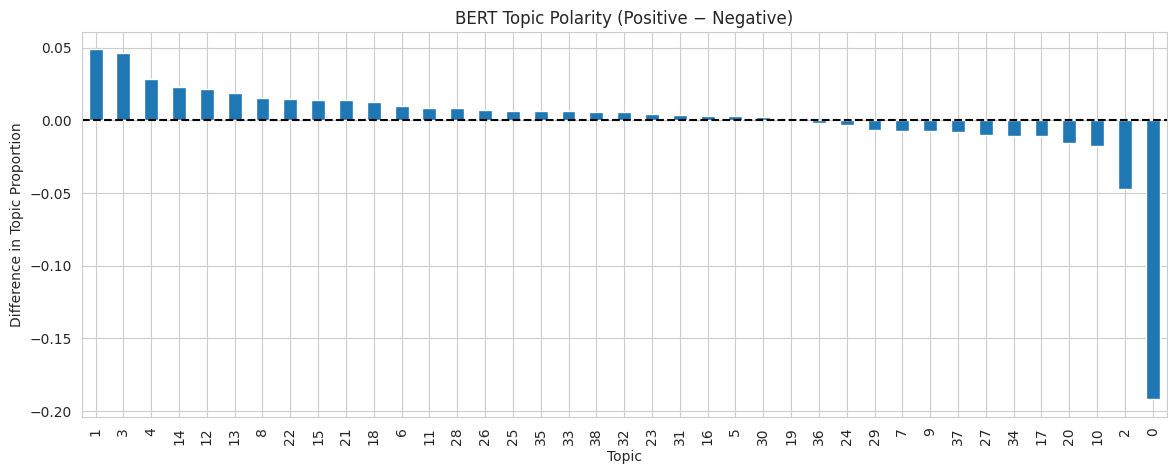

In [59]:
# lda VS BERT
topic_diff.plot(
    kind='bar',
    figsize=(14, 5),
    title="LDA Topic Polarity (Positive − Negative)"
)

plt.axhline(0, linestyle='--', color='black')
plt.ylabel("Difference in Average Topic Probability")
plt.xlabel("Topic")
plt.show()

topic_diff_bert.plot(
    kind='bar',
    figsize=(14, 5),
    title="BERT Topic Polarity (Positive − Negative)"
)

plt.axhline(0, linestyle='--', color='black')
plt.ylabel("Difference in Topic Proportion")
plt.xlabel("Topic")
plt.show()
